# 0. Config

In [139]:
# General
import ee
import folium
import geopandas as gpd
import tensorflow as tf

In [152]:
# Modelling
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses, models, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import keras

In [141]:
ee.Initialize()

In [142]:
# Creating add_ee_layer function
# This allows us to visualise EE objects on a Folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee_image_object.getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name = name,
        overlay = True,
        control = True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# 1. Uploading the data to train the model

**! IMPORTANT NOTE !**
- `THEMIS_DAYIR_TT_MergedMosaic.tif` covers all of the areas where faults are drawn, and is in EPSG 3857.
- Tried to upload `THEMIS_DAYIR_TT_MergedMosaic.tif` directly to Earth Engine to path `projects/esg-satelite/assets/mars/features/themis_v1/pre/themis` but kept getting the following error: `Error: No data value 256.0 cannot be applied to band #0 of type Short<0, 255>. (Error code: 3)`
- Instead uploaded `THEMIS_DAYIR_TT_MergedMosaic.tif` to GCP to path `gs://esg-satelite-data-warehouse/mars/features/themis_v1/raw/THEMIS_DayIR_TT_MergedMosaic.tif` but the image still could not be programatically moved to EE.
- Temporarily going to use the image with path `projects/esg-satelite/assets/mars/features/themis_epsg3857_sample/pre/themis_epsg3857_sample`. This may actually be the same image.

In [15]:
themis = ee.Image("projects/esg-satelite/assets/mars/features/themis_epsg3857_sample/pre/themis_epsg3857_sample")

# 2. Get the data labels

In [32]:
# Read in the fault line vectors.
faultlines = ee.FeatureCollection("projects/esg-satelite/assets/mars/labels/faults/pre/faults")

# 3. Get train, val, and test areas for training

## 3.1. Define the train, val, test areas

In [47]:
# Defining the train, val, test areas of THEMIS
PATCHES_JSON = {
  "type": "FeatureCollection",
  "features": [
    # TRAIN
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -47.4,
              20.6
            ],
            [
              -38.9,
              20.6
            ],
            [
              -38.9,
              17.4
            ],
            [
              -47.4,
              17.4,
            ],
            [
              -47.4,
              20.6
            ]
          ]
        ],
        "type": "Polygon"
      }
    },
    # VAL
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -35.6,
              26.4
            ],
            [
              -35.6,
              24.3
            ],
            [
              -39.3,
              24.3
            ],
            [
              -39.3,
              26.4
            ],
            [
              -35.6,
              26.4
            ]
          ]
        ],
        "type": "Polygon"
      }
    },
    # TEST
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -42.7,
              23.6
            ],
            [
              -39.0,
              23.6
            ],
            [
              -39.0,
              21.5
            ],
            [
              -42.7,
              21.5
            ],
            [
              -42.7,
              23.6
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
PATCHES = ee.FeatureCollection(PATCHES_JSON)

In [48]:
# View the train, val, and test areas on a map
Map = folium.Map(location = [22.7, -38], zoom_start = 5)

Map.add_ee_layer(
    themis,
    {},
    "Mars THEMIS"
)

Map.add_ee_layer(
    faultlines,
    {"min": 0, "max": 1, "color": "red"},
    "Fault Lines"
)

Map.add_ee_layer(
    PATCHES,
    {},
    "Regions"
)

_ = folium.LayerControl().add_to(Map)

Map

- Bottom: Train
    - x width = 8.5 deg
    - y height = 3.2 deg
- Top: Val
    - x width = 3.7 deg
    - y height = 2.1 deg
- Middle: Test
    - x width = 3.7 deg
    - y height = 2.1 deg

**! IMPORTANT NOTE !**
- Attempts have been made to separate the train, val, and test areas such that sample images taken won't overlap.
- However, this may not be guaranteed, and needs checking.

## 3.2. Generate data samples from these areas

### 3.2.1 Create faultline raster

In [49]:
# Add a columns of ones 
# This assigns each geometry (each fault/vector) to the value 1
# and assigns every other space to nothing (which we will fix later)
def add_column(feature):
    return feature.set({"Value": 1})

faultline_vectors_with_ones = faultlines.map(add_column)

faultlines_raster = (
    # Convert to image
    faultline_vectors_with_ones.reduceToImage(
        properties=["Value"],
        reducer=ee.Reducer.first()
    )
    # Change band name "first"  to "FAULTLINE" 
    .select(["first"], ["FAULTLINE"])
    # Unmask, which changes all non-fault pixels to have value 0
    .unmask(0)
)

### 3.2.2. Stack the features and the labels

In [50]:
# Create stack
image_stack = ee.Image.cat(
    [
        faultlines_raster,
        themis
    ]
)

In [51]:
image_stack = image_stack.float()

### 3.3.3. Sample the stack in the areas

In [81]:
KERNEL_SIZE = 128

In [53]:
# Makes a 64x64 tensor of 1s
# This is because we want, for each pixel, to take every 64x64 pixel around that one
# The 1s just mean we aren't applying any kind of transformation
ee_list = ee.List.repeat(1,KERNEL_SIZE)
ee_lists = ee.List.repeat(ee_list,KERNEL_SIZE)
kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, ee_lists)

image_stack_neighbours = image_stack.neighborhoodToArray(kernel)

- We generate..
    - 4000 sample images for the train set
    - 1000 for the validation set
    - 1000 for the test set
    - all of size 128x128
    - all of scale 500
- The validation (and test) set is 28% the size of the train set; this is where the 1000 vs 4000 came from.

In [75]:
patch_list = PATCHES.toList(PATCHES.size())

task_list = []
names = ["train", "val", "test"]
number_of_shards = [400, 100, 100]
sample_size = [4000, 1000, 1000]

# Extracts feature from the feature collection, and gets the geom property
for geometry_index in range(PATCHES.size().getInfo()):
    
    image_stack_sample = ee.FeatureCollection([])
    for i in range(number_of_shards[geometry_index]):
        
        sample = image_stack_neighbours.sample(
            region=ee.Feature(patch_list.get(geometry_index)).geometry(),
            scale=500,
            numPixels=(sample_size[geometry_index])/(number_of_shards[geometry_index]),
            seed=i
        )
        image_stack_sample = image_stack_sample.merge(sample)
        
    desc = f"Features and Labels for region: {names[geometry_index]}"
    task = ee.batch.Export.table.toCloudStorage(
        collection=image_stack_sample,
        description=desc,
        bucket="esg-satelite-data-warehouse",
        fileNamePrefix=f"mars/modelling/themis_v1/data_{names[geometry_index]}",
        fileFormat = "TFRecord"
    )
    task_list.append(task)

In [76]:
for task in task_list:
    task.start()

In [80]:
task_list[0].status()

{'state': 'RUNNING',
 'description': 'Features and Labels for region: train',
 'creation_timestamp_ms': 1697662221256,
 'update_timestamp_ms': 1697662341174,
 'start_timestamp_ms': 1697662243611,
 'task_type': 'EXPORT_FEATURES',
 'attempt': 1,
 'id': 'BS55TCITDQWCD4XYOZ5ZNDPQ',
 'name': 'projects/earthengine-legacy/operations/BS55TCITDQWCD4XYOZ5ZNDPQ'}

# 4. Train the model

In [83]:
BANDS = ["b1"]
RESPONSE = "FAULTLINE"
FEATURES = BANDS + [RESPONSE]

COLUMNS = [
    tf.io.FixedLenFeature(shape=[KERNEL_SIZE, KERNEL_SIZE], dtype=tf.float32) for _ in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

In [84]:
def parse_tfrecord(example_proto):
    """The parsing function.
    Read a serialized example into the structure defined by FEATURES_DICT.
    Args:
    example_proto: a serialized Example.
    Returns:
    A dictionary of tensors, keyed by feature name.
    """
    return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """
    inputsList = [inputs.get(key) for key in FEATURES]
    stacked = tf.stack(inputsList, axis=0)
    # Convert from CHW to HWC
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked[:,:,:len(BANDS)], tf.squeeze(tf.cast(stacked[:,:,len(BANDS):], tf.int32))


def get_dataset(pattern):
    """Function to read, parse and format to tuple a set of input tfrecord files.
    Get all the files matching the pattern, parse and convert to tuple.
    Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
    Returns:
    A tf.data.Dataset
    """
    glob = tf.io.gfile.glob(pattern)
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
    dataset = dataset.map(to_tuple, num_parallel_calls=5)
    return dataset

In [85]:
tf.random.set_seed(42)

## 4.1. Get the TensorFlow records

In [86]:
BATCH_SIZE = 16
BUFFER_SIZE = 2000

base_path = "gs://esg-satelite-data-warehouse/mars/modelling/themis_v1"


train_data_path = f"{base_path}/data_train.tfrecord.gz"
test_data_path = f"{base_path}/data_test.tfrecord.gz"
val_data_path = f"{base_path}/data_val.tfrecord.gz"

train_data_raw = get_dataset(train_data_path)
test_data_raw = get_dataset(test_data_path)
val_data_raw = get_dataset(val_data_path)


training_data = train_data_raw.shuffle(BUFFER_SIZE, reshuffle_each_iteration = False).batch(BATCH_SIZE)
test_data = test_data_raw.shuffle(BUFFER_SIZE, reshuffle_each_iteration = False).batch(BATCH_SIZE)
val_data = val_data_raw.shuffle(BUFFER_SIZE, reshuffle_each_iteration = False).batch(BATCH_SIZE)

2023-10-18 20:56:57.330866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 20:56:57.341926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 20:56:57.343487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 20:56:57.369913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

## 4.2. Define model

In [162]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

def get_model(
    optimizer,
    loss,
    metrics
):

    normalisation_layer = layers.Normalization()
    normalisation_layer.adapt(training_data.map(lambda x, _: x))

    inputs = layers.Input(shape=[None, None, len(BANDS)]) # 256
    normalised_inputs = normalisation_layer(inputs)
    encoder0_pool, encoder0 = encoder_block(normalised_inputs, 32) # 128
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
    center = conv_block(encoder4_pool, 1024) # center
    decoder4 = decoder_block(center, encoder4, 512) # 16
    decoder3 = decoder_block(decoder4, encoder3, 256) # 32
    decoder2 = decoder_block(decoder3, encoder2, 128) # 64
    decoder1 = decoder_block(decoder2, encoder1, 64) # 128
    decoder0 = decoder_block(decoder1, encoder0, 32) # 256
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(decoder0)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )
    return model

In [163]:
# Ref: https://stackoverflow.com/questions/51793737/custom-loss-function-for-u-net-in-keras-using-class-weights-class-weight-not
def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        #axis = -1 #if channels last 
        axis=  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(int(i), int(classSelectors)) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier
            
        return loss
    return lossFunc

## 4.3. Train the model

- optimizer
    - `optimizers.SGD(learning_rate=0.1)`
    - `optimizer.Adam()`
- loss
    - `losses.BinaryCrossentropy()`
    - ` weightedLoss(keras.losses.binary_crossentropy, [0.1,0.9])`

In [164]:
model = get_model(    
    optimizer = optimizers.Adam(),
    loss=weightedLoss(keras.losses.binary_crossentropy, [0.05,0.95]),
    metrics=[
        metrics.BinaryIoU(target_class_ids=[1], name = "iou")
    ]
)

callbacks = []
es = EarlyStopping(
    monitor= "val_loss", #"val_iou",
    patience=10,
    verbose=1,
    mode="min", #"max"
    restore_best_weights=True,
)
callbacks.append(es)

EPOCHS = 100

history = model.fit(
    x=training_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks = callbacks
)

Epoch 1/100
250/250 [==============================] - 54s 148ms/step - loss: 0.0306 - iou: 0.4302 - val_loss: 0.0384 - val_iou: 0.1933
Epoch 2/100
250/250 [==============================] - 38s 143ms/step - loss: 0.0245 - iou: 0.5149 - val_loss: 0.0326 - val_iou: 0.3594
Epoch 3/100
250/250 [==============================] - 38s 143ms/step - loss: 0.0219 - iou: 0.5551 - val_loss: 0.0354 - val_iou: 0.3502
Epoch 4/100
250/250 [==============================] - 37s 143ms/step - loss: 0.0193 - iou: 0.5954 - val_loss: 0.0377 - val_iou: 0.3340
Epoch 5/100
250/250 [==============================] - 38s 143ms/step - loss: 0.0171 - iou: 0.6261 - val_loss: 0.0393 - val_iou: 0.3392
Epoch 6/100
250/250 [==============================] - 37s 142ms/step - loss: 0.0155 - iou: 0.6498 - val_loss: 0.0420 - val_iou: 0.3392
Epoch 7/100
250/250 [==============================] - 38s 143ms/step - loss: 0.0142 - iou: 0.6668 - val_loss: 0.0435 - val_iou: 0.3424
Epoch 8/100
250/250 [===========================

In [165]:
model.save("gs://esg-satelite-data-warehouse/mars/models/model_v1")

INFO:tensorflow:Assets written to: gs://esg-satelite-data-warehouse/mars/models/model_v1/assets


INFO:tensorflow:Assets written to: gs://esg-satelite-data-warehouse/mars/models/model_v1/assets


# 5. Test the model

In [182]:
def get_test_statistics(model, data, thresh = 0.5):
    ious = []
    for i in range(5):
        x_data = np.expand_dims(np.concatenate([x for x, _ in data], axis=0)[i], axis=0)
        y_true = np.expand_dims(np.concatenate([y for _, y in data], axis=0)[i], axis=0)
        # Get predictions
        y_pred_prob = model.predict(x_data)
        y_pred_binary = (y_pred_prob > thresh)*1
        # Get IOU metric
        iou_metric = metrics.BinaryIoU(target_class_ids=[1], name = "iou")
        iou_metric.update_state(y_true=y_true, y_pred=y_pred_prob)
        iou_value = iou_metric.result().numpy()
        ious.append(iou_value)
    print(f"Mean IOU: {np.mean(ious):.3f}")

In [190]:
def disp_predictions(model, data, n = 1, thresh = 0.5):
    ious = []
    for i in range(n):
        x_data = np.expand_dims(np.concatenate([x for x, _ in data], axis=0)[i], axis=0)
        y_true = np.expand_dims(np.concatenate([y for _, y in data], axis=0)[i], axis=0)
        # Get predictions
        y_pred_prob = model.predict(x_data)
        y_pred_binary = (y_pred_prob > thresh)*1
        # Get IOU metric
        iou_metric = metrics.BinaryIoU(target_class_ids=[1], name = "iou")
        iou_metric.update_state(y_true=y_true, y_pred=y_pred_prob)
        iou_value = iou_metric.result().numpy()
        ious.append(iou_value)
        plot_results(x_data[:,:,:,:1].squeeze(), y_true[0], y_pred_prob[0], y_pred_binary[0], title = f"IOU: {iou_value}") 
    print(f"Mean IOU: {np.mean(ious):.3f}")

In [184]:
def plot_results(x_train, y_train, x_pred_prob, x_pred_binary, title):
    fig, axs = plt.subplots(2,2)
    
    axs[0, 0].imshow(x_train)
    _ = axs[0, 0].axis('off')
    _ = axs[0, 0].set_title('Real Image') 
    
    axs[0, 1].imshow(y_train)
    _ = axs[0, 1].axis('off')
    _ = axs[0, 1].set_title('Real Faults')
    
    axs[1, 0].imshow(x_pred_prob)
    _ = axs[1, 0].axis('off')
    _ = axs[1, 0].set_title('Predicted Fault (prob)')
    
    axs[1, 1].imshow(x_pred_binary)
    _ = axs[1, 1].axis('off')
    _ = axs[1, 1].set_title('Predicted Fault (bin)')
    
    plt.suptitle(title)

In [183]:
get_test_statistics(
    model = model, 
    data = test_data, 
    thresh = 0.5
)

1/1 [==============================] - 0s 28ms/step
Mean IOU: 0.437


1/1 [==============================] - 0s 32ms/step
Mean IOU: 0.426


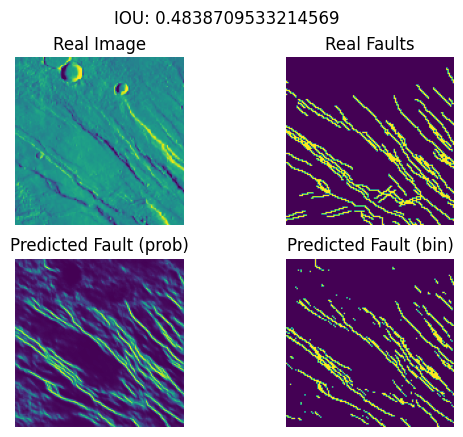

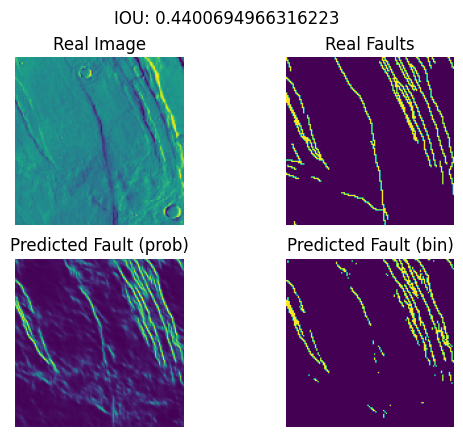

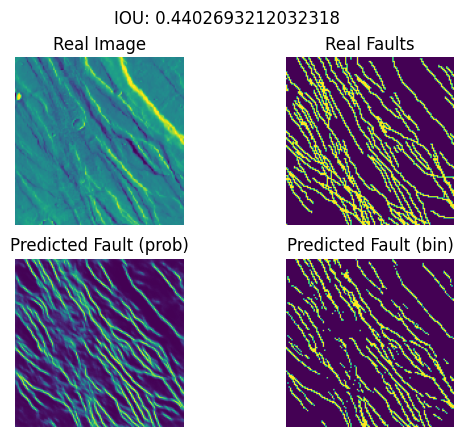

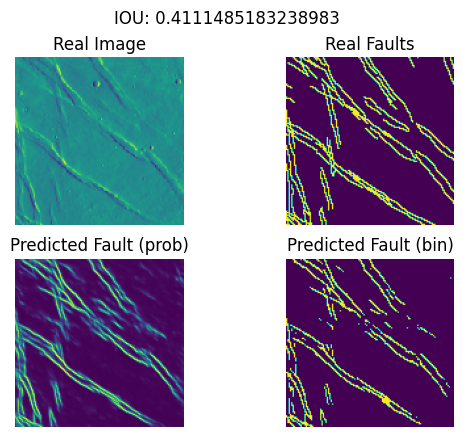

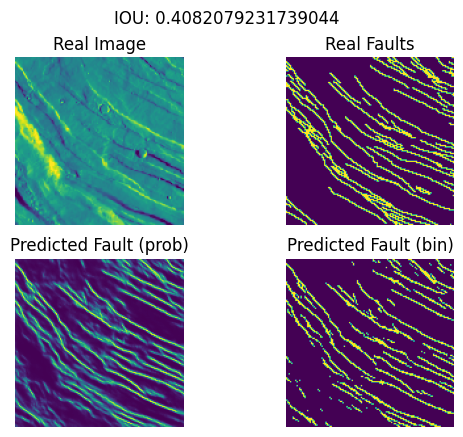

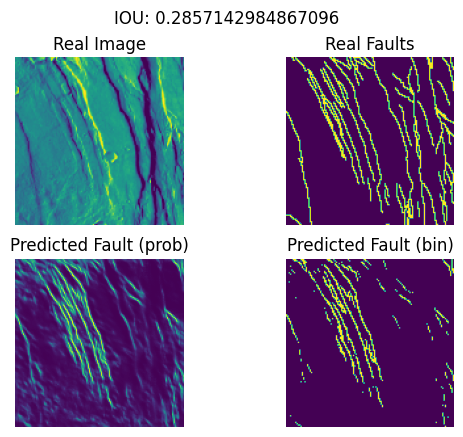

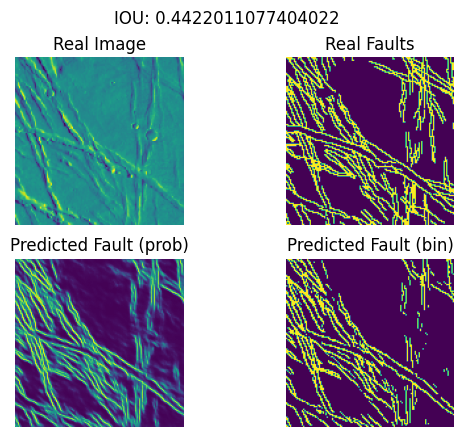

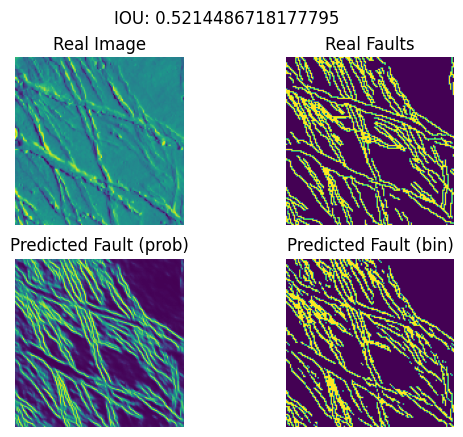

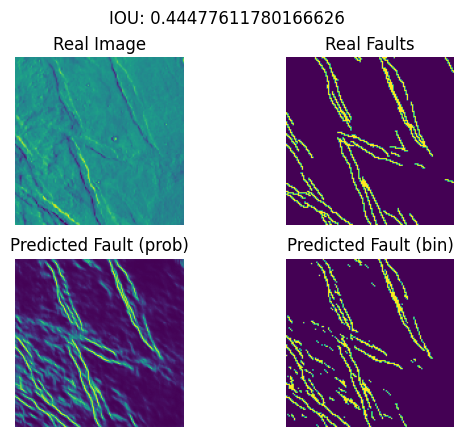

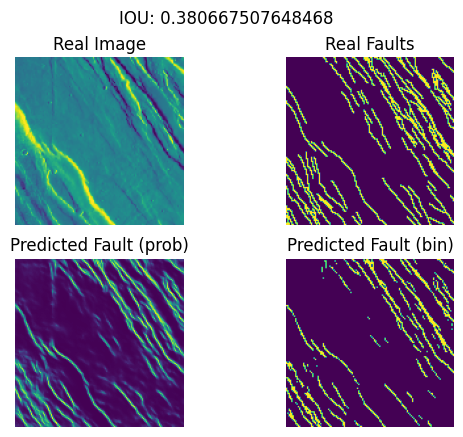

In [192]:
disp_predictions(
    model = model, 
    data = test_data, 
    n = 10, 
    thresh = 0.5
)